# Интерфейс к модели MNIST с обучением, AutoML и инференсом

Данный проект представляет собой полноценное веб-приложение на Streamlit, которое работает внутри Google Colab и включает:

- Ручное обучение модели MNIST

- AutoML подбор гиперпараметров через Keras Tuner

- Инференс по загруженной картинке

- Рисование цифры в Canvas + улучшенная предобработка

- Сохранение и загрузка обученной модели

- Автоматический запуск через ngrok

## Установка библиотек

In [ ]:
!pip install streamlit tensorflow streamlit-drawable-canvas pillow pyngrok

In [10]:
!pip install -q keras-tuner


# App Streamlit

### Создание файла app.py

In [11]:
%%writefile app.py
# Импорт библиотек
import streamlit as st
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
import os, traceback
# try keras-tuner
try:
    import keras_tuner as kt
    KT_AVAILABLE = True
except Exception:
    KT_AVAILABLE = False

# try drawable canvas
try:
    from streamlit_drawable_canvas import st_canvas
    CANVAS_AVAILABLE = True
except Exception:
    CANVAS_AVAILABLE = False
# Настройки страницы Streamlit
# Устанавливаем тему, тёмный стиль и CSS
st.set_page_config(page_title="MNIST — Train / AutoML / Inference", layout="centered", initial_sidebar_state="auto")
st.markdown(
    """
    <style>
    .stApp { font-family: Inter, system-ui, -apple-system, "Segoe UI", Roboto; background:#1e1e1e; color:#ffffff; }
    .card { background:#282828; border-radius:10px; padding:20px; box-shadow:0 1px 6px rgba(0,0,0,0.1); margin-bottom:15px; color:#ffffff; }
    .muted { color:#a0a0a0; font-size:13px; margin-bottom:10px }
    h2 { margin: 6px 0; color:#ffffff; }
    </style>
    """, unsafe_allow_html=True
)
# Session State
# Создаём переменные состояния приложения
for key, default in {
    "model": None,
    "latest_model_path": None,
    "tuner_results": [],
    "tuner_best_hps": None,
    "tuner_running": False,
    "last_canvas_image": None,
    "canvas_key": 0
}.items():
    if key not in st.session_state:
        st.session_state[key] = default
# Функции вспомогательной обработки
# Preprocess для файлов и для канваса
def preprocess_pil_to_array(img: Image.Image):
    """Для загружаемых изображений."""
    img = img.convert("L")
    img = ImageOps.invert(img)
    img = img.resize((28, 28))
    arr = np.array(img).astype("float32") / 255.0
    return arr
def preprocess_canvas_improved(canvas_img):
    """
    Преобразует canvas RGBA изображение в массив 28x28, близкий к MNIST стилю:
    - берёт канал R (или G, B) для чёрной цифры на белом фоне.
    - инвертирует цвета, чтобы получить белую цифру на чёрном фоне.
    - обрезает по bounding box,
    - ресайзит до 20×20,
    - центрирует в 28×28,
    - размывает (антиалиасинг).
    """
    # Use the Red channel (or G or B) directly for the digit.
    # For black stroke on white background, R=0 for digit, R=255 for background.
    img_grayscale = Image.fromarray(canvas_img[:, :, 0].astype(np.uint8))

    # Invert colors: black digit on white background becomes white digit on black background
    img_inverted = ImageOps.invert(img_grayscale)

    # Threshold the image to make it purely binary (0 or 255) for robust bbox calculation
    # All pixels > 0 become 255, 0 remains 0. This ensures a clean white digit on black.
    img_binary = img_inverted.point(lambda p: 255 if p > 0 else 0)

    bbox = img_binary.getbbox() # Use binary image for bbox

    if bbox is not None:
        left, upper, right, lower = bbox
        # Expand bounding box slightly for better context, clamping to image bounds
        left = max(left - 3, 0) # increased margin slightly
        upper = max(upper - 3, 0)
        right = min(right + 3, img_inverted.width)
        lower = min(lower + 3, img_inverted.height)

        # Crop the original inverted image (not binary) with the new bbox
        # This preserves the anti-aliasing of the original drawing
        img_cropped = img_inverted.crop((left, upper, right, lower))
    else:
        # If nothing was drawn, return an all-black 28x28 image
        arr = np.zeros((28, 28), dtype=np.float32)
        return arr

    # If the cropped image is empty (e.g. very faint drawing), return black
    if img_cropped.width == 0 or img_cropped.height == 0:
        arr = np.zeros((28, 28), dtype=np.float32)
        return arr

    # Resize the cropped image to 20x20, maintaining aspect ratio.
    # Use Image.LANCZOS for high-quality downsampling.
    img_resized = img_cropped.resize((20, 20), Image.Resampling.LANCZOS)

    # Apply a light Gaussian blur for smoothing/anti-aliasing, as in MNIST
    img_blurred = img_resized.filter(ImageFilter.GaussianBlur(radius=0.5)) # Reduced blur radius

    # Create a new 28x28 black image
    final_img = Image.new("L", (28, 28), color=0)

    # Calculate paste position to center the 20x20 digit in the 28x28 canvas
    paste_x = (28 - img_blurred.width) // 2
    paste_y = (28 - img_blurred.height) // 2
    final_img.paste(img_blurred, (paste_x, paste_y))

    # Convert to numpy array and normalize to [0, 1]
    arr = np.array(final_img).astype("float32") / 255.0
    return arr
# Predict + загрузка модели
def predict_image(model, arr):
    x = np.asarray(arr).astype("float32")
    ishape = model.input_shape
    # приводим форму под модель
    if len(ishape) == 4:
        _, h, w, c = ishape
        c = c or 1
        if x.ndim == 2:
            x = x.reshape(1, h, w, c)
    elif len(ishape) == 3:
        _, h, w = ishape
        if x.ndim == 2:
            x = x.reshape(1, h, w)
    preds = model.predict(x)
    probs = preds[0]
    return int(np.argmax(probs)), probs
def load_model_path(path):
    try:
        m = keras.models.load_model(path)
        st.session_state["model"] = m
        st.session_state["latest_model_path"] = path
        st.success(f"Model loaded from {path}")
        return True
    except Exception as e:
        st.error("Failed to load model: " + str(e))
        st.text_area("Traceback", traceback.format_exc(), height=200)
        return False
# Модели: ручная и AutoML
def build_manual_model(lr, dropout):
    model = models.Sequential([
        layers.Flatten(input_shape=(28,28)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(128, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model
def build_autotune_model(hp):
    model = models.Sequential([
        layers.Flatten(input_shape=(28,28)),
        layers.Dense(hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)),
        layers.Dense(hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)),
        layers.Dense(10, activation='softmax')
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
# Оформление заголовка
st.markdown("<div class='card'>", unsafe_allow_html=True)
st.markdown("<h2>MNIST</h2><div class='muted'>Manual training · AutoML tuning · Inference (drawing/upload)</div>", unsafe_allow_html=True)

tabs = st.tabs(["Train (manual)", "AutoML", "Inference"])
# Вкладка "Train (manual)"
with tabs[0]:
    st.markdown("#### Manual training")
    with st.expander("Settings", expanded=False):
        lr = st.number_input("Learning rate", value=1e-3, format="%.5f")
        epochs = st.slider("Epochs", 1, 10, 3)
        batch = st.selectbox("Batch size", [32,64,128], index=0)
        dropout = st.slider("Dropout", 0.0, 0.5, 0.2)

    if st.button("Start manual training"):
        (x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()
        x_train, x_test = x_train/255.0, x_test/255.0
        model = build_manual_model(lr, dropout)
        loss_chart = st.empty(); acc_chart = st.empty()
        losses, accs = [], []
        for e in range(epochs):
            h = model.fit(x_train, y_train, epochs=1, batch_size=batch, verbose=0,
                          validation_data=(x_test,y_test))
            losses.append(h.history["loss"][0])
            accs.append(h.history["accuracy"][0])
            f,a = plt.subplots(); a.plot(losses,marker="o"); a.set_title("Loss"); loss_chart.pyplot(f); plt.close(f)
            f2,a2 = plt.subplots(); a2.plot(accs,marker="o"); a2.set_title("Accuracy"); acc_chart.pyplot(f2); plt.close(f2)
            st.write(f"Epoch {e+1}/{epochs} — loss {losses[-1]:.4f} acc {accs[-1]:.4f}")
        test_loss, test_acc = model.evaluate(x_test,y_test,verbose=0)
        st.success(f"Manual training done — test acc: {test_acc:.4f}")
        path = "mnist_manual.h5"
        model.save(path)
        st.success(f"Saved {path}")
        load_model_path(path)
# Вкладка AutoML
with tabs[1]:
    st.markdown("#### AutoML Hyperparameter Tuning")
    if not KT_AVAILABLE:
        st.warning("Keras Tuner not installed. Please install it using `!pip install -q keras-tuner`")
    else:
        with st.expander("Settings", expanded=False):
            max_trials = st.slider("Max trials", 5, 20, 10)
            executions_per_trial = st.slider("Executions per trial", 1, 3, 1)
            epochs_per_trial = st.slider("Epochs per trial", 1, 10, 3)

        if st.button("Start AutoML Tuning", key="start_automl_tuning") and not st.session_state["tuner_running"]:
            st.session_state["tuner_running"] = True
            (x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()
            x_train, x_test = x_train/255.0, x_test/255.0

            tuner = kt.RandomSearch(
                build_autotune_model,
                objective='val_accuracy',
                max_trials=max_trials,
                executions_per_trial=executions_per_trial,
                directory='keras_tuner_dir',
                project_name='mnist_tuning'
            )

            st.write("Starting tuner search...")
            tuner.search(x_train, y_train, epochs=epochs_per_trial, validation_data=(x_test, y_test), verbose=0)

            st.write("Tuner search complete.")
            best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
            st.session_state["tuner_best_hps"] = best_hps
            st.write("Best hyperparameters found:")
            st.json(best_hps.values)

            best_model = tuner.get_best_models(num_models=1)[0]
            test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
            st.success(f"AutoML tuning done — best model test acc: {test_acc:.4f}")

            path = "mnist_best_model.h5"
            best_model.save(path)
            st.success(f"Saved best model to {path}")
            load_model_path(path)
            st.session_state["tuner_running"] = False

        if st.session_state["tuner_best_hps"] is not None:
            st.markdown("### Latest Tuner Results")
            st.json(st.session_state["tuner_best_hps"].values)
            if st.button("Load Best AutoML Model"):
                if os.path.exists("mnist_best_model.h5"):
                    load_model_path("mnist_best_model.h5")
                else:
                    st.error("No best model found. Please run AutoML tuning first.")
# Вкладка Inference
with tabs[2]:
    st.markdown("#### Inference")

    available_models = []
    if os.path.exists("mnist_manual.h5"):
        available_models.append("mnist_manual.h5")
    if os.path.exists("mnist_best_model.h5"):
        available_models.append("mnist_best_model.h5")

    selected_model_path = None
    if st.session_state["latest_model_path"] and st.session_state["latest_model_path"] in available_models:
        default_index = available_models.index(st.session_state["latest_model_path"])
        selected_model_path = st.selectbox("Choose a model for inference", available_models, index=default_index)
    elif available_models:
        selected_model_path = st.selectbox("Choose a model for inference", available_models)
    else:
        st.info("No models available. Please train a model first.")

    if selected_model_path and st.session_state["latest_model_path"] != selected_model_path:
        load_model_path(selected_model_path)

    model = st.session_state.get("model")
    if model is None:
        st.info("No model loaded. Train or upload a model.")
    else:
        st.success("Model ready")
        uploaded_file = st.file_uploader("Upload an image", type=["png", "jpg", "jpeg"])
        if uploaded_file is not None:
            img = Image.open(uploaded_file)
            st.image(img, width=160)
            arr = preprocess_pil_to_array(img)
            pred, probs = predict_image(model, arr)
            st.metric("Predicted", pred)
            st.write("Probs:")
            top_5_indices = np.argsort(probs)[::-1][:5] # Get indices of top 5 probabilities
            for i in top_5_indices:
                st.write(f"{i}: {probs[i]:.4f}")
# Drawing canvas
st.markdown("**Draw a digit**")
st.write("Нарисуйте на холсте ниже, потом нажмите ‘Predict Drawing’.")
st.image("https://abpaudel.com/assets/img/posts/mnist.png")

if CANVAS_AVAILABLE:
    col_canvas, col_results = st.columns([1, 1])

    with col_canvas:
        c1, c2 = st.columns([1, 1])
        with c1:
            st.button("Refresh canvas", on_click=lambda: st.session_state.update({"canvas_key": st.session_state["canvas_key"] + 1}))
        with c2:
            st.button("Clear drawing", on_click=lambda: st.session_state.update({"last_canvas_image": None}))

        canvas_res = st_canvas(
            fill_color="rgba(0,0,0,1)",
            stroke_width=14,
            stroke_color="black",
            background_color="white",
            width=280,
            height=280,
            drawing_mode="freedraw",
            key=f"c-{st.session_state['canvas_key']}"
        )

    with col_results:
        if st.button("Predict Drawing"):
            if canvas_res.image_data is not None and st.session_state.get("model") is not None:
                arr = preprocess_canvas_improved(canvas_res.image_data)
                st.image(arr, caption='Preprocessed Canvas Image', width=160) # <--- Added visualization
                pred, probs = predict_image(st.session_state["model"], arr)
                st.metric("Predicted digit", pred)
                st.write("Top 5 Probs:")
                top_5_indices = np.argsort(probs)[::-1][:5] # Get indices of top 5 probabilities
                for i in top_5_indices:
                    st.write(f"{i}: {probs[i]:.4f}")
            else:
                st.info("Нарисуйте цифру и убедитесь, что модель загружена/обучена.")

Overwriting app.py


# Запуск Streamlit + ngrok

### Импорт

In [12]:
from pyngrok import ngrok
import subprocess
import time
from google.colab import userdata

### Инструкция по настройке ngrok в Google Colab

#### Шаг 1 — Получить токен ngrok

- Перейди на сайт: https://dashboard.ngrok.com

- Создай аккаунт (Google / GitHub / email).

- Открой страницу токена:
**Left menu → Your Authtoken**

- Скопируй строку вида:
```bash
2u93hfj3k_OqIxxxxxxXSFDSFDSFDSFDSFDSFDS
```


#### Шаг 2 — Добавить токен в переменные Google Colab

В Colab открой:

**Меню → Tools → Variables → Add new variable**

Добавь:

Name: *NGROK_AUTH*

Value: твой токен 2u93hfj3k_OqI...

Сохрани.

In [13]:
NGROK_TOKEN = userdata.get("NGROK_AUTH")

## Авторизация ngrok

In [14]:
ngrok.set_auth_token(NGROK_TOKEN)

## Запускаем Streamlit сервер

In [15]:
print("Запускаем Streamlit...")
process = subprocess.Popen(["streamlit", "run", "app.py"])

Запускаем Streamlit...


## Создаем туннель

In [16]:
time.sleep(5)  # ждём старт сервера
public_url = ngrok.connect(8501)
print("Ваш публичный URL:")
print(public_url)

Ваш публичный URL:
NgrokTunnel: "https://unannexed-unetymologically-michiko.ngrok-free.dev" -> "http://localhost:8501"


В ходе работы был создан полнофункциональный веб-интерфейс для нейронной сети MNIST, включающий обучение, автоматический подбор гиперпараметров и инференс. Приложение позволяет пользователю обучать модели вручную, выполнять AutoML-поиск оптимальных настроек с помощью Keras Tuner, просматривать качество работы моделей и применять их к новым изображениям.

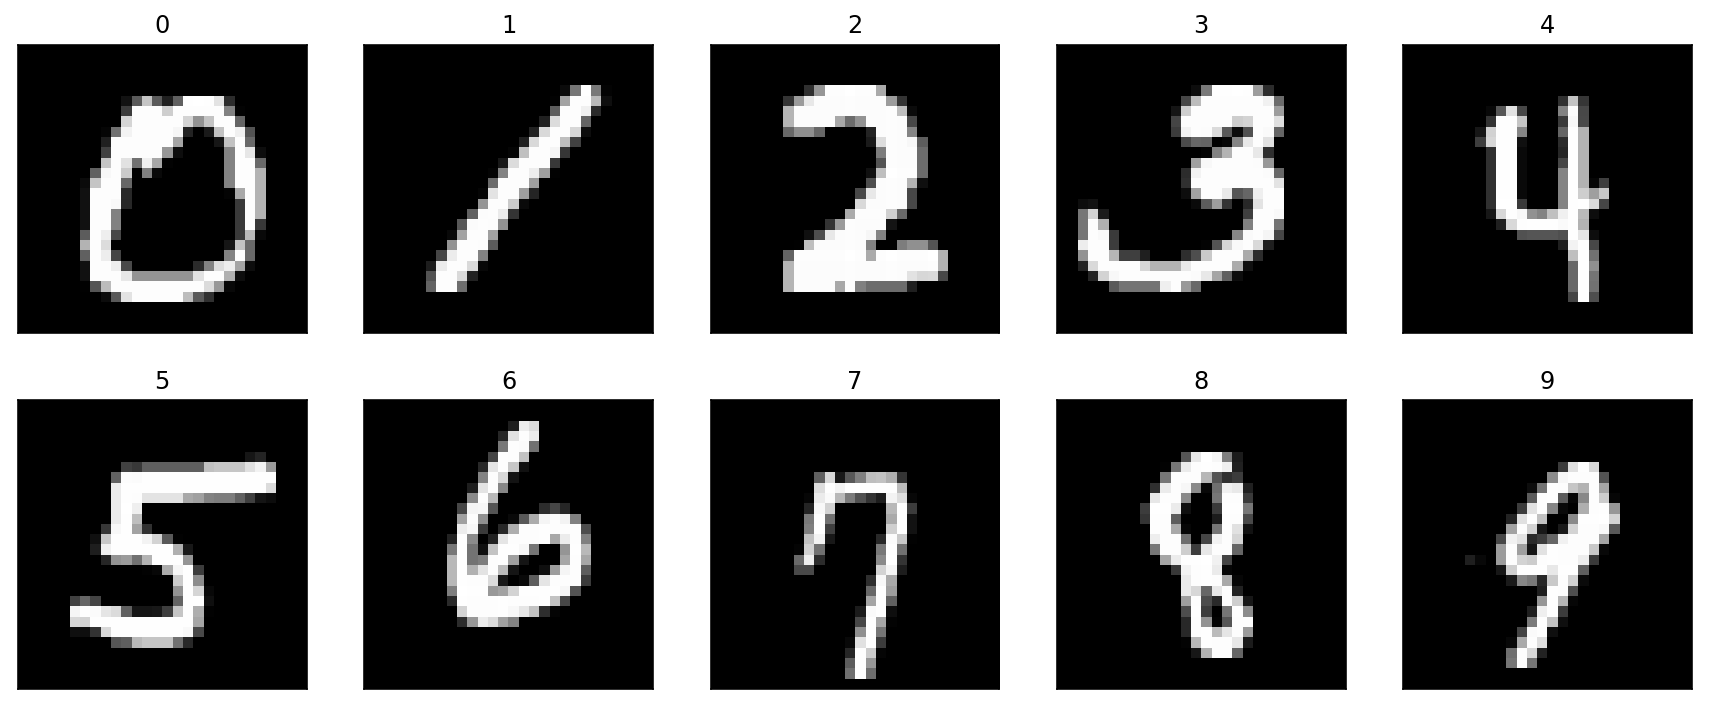